In [1]:
import warnings;
warnings.simplefilter('ignore')

# Install and Import Dependencies

In [2]:
# !pip install pystan prophet  ## If you don't have pystand and prophet installed run this cell.

In [3]:
import pandas as pd
from prophet import Prophet

# Data Preprocessing

In [4]:
# Read the data into a Pandas DataFrame
ecommerce_df = pd.read_csv('../Resources/Ecommerce_Data_Updated.csv')
print(f"{ecommerce_df.shape} is the number of the rows and columns in the dataset.")
ecommerce_df.head()

(9994, 18) is the number of the rows and columns in the dataset.


,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Sales Per Unit,Original Unit Price,Lead Time
0,2022-11-07,2022-11-10,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,130.9800,130.98,3 days
1,2022-11-07,2022-11-10,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820,243.9800,243.98,3 days
2,2022-06-11,2022-06-15,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,7.3100,7.31,4 days
3,2021-10-09,2021-10-16,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310,191.5155,348.21,7 days
4,2021-10-09,2021-10-16,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,11.1840,13.98,7 days


In [5]:
# Check the columns
print(f"{len(ecommerce_df.columns)} --> is the number of columns in our DataFrame.")
ecommerce_df.columns

18 --> is the number of columns in our DataFrame.


Index(['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'Country', 'City',
       'State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Sales Per Unit',
       'Original Unit Price', 'Lead Time'],
      dtype='object')

In [6]:
# Drop unwanted columns    ## Keeping only numerical columns so we can get the average of each column per "Order Date"
ecommerce_df = ecommerce_df.drop(columns = ["Ship Date", "Ship Mode", "Segment",
                                            "Country", "City", "State", "Postal Code", 
                                            "Sales Per Unit", "Lead Time",
                                            "Category", "Sub-Category", 
                                            "Region"])  ## I might keep the Region when predicting the "Sales"


# printing the number of rows and columns
print(ecommerce_df.shape) 
# print the DataFrame in descending order - starting from the most recent date.
ecommerce_df.sort_values(by = "Order Date", ascending = False).head() 

(9994, 6)


,Order Date,Sales,Quantity,Discount,Profit,Original Unit Price
906,2023-12-29,323.136,4,0.2,12.1176,100.98
907,2023-12-29,90.930,7,0.0,2.7279,12.99
1296,2023-12-29,13.904,2,0.2,4.5188,8.69
1297,2023-12-29,20.720,2,0.2,6.4750,12.95
645,2023-12-29,209.300,2,0.0,56.5110,104.65


In [7]:
## Group by the "Order Date" Then take the average of each column
ecommerce_df = ecommerce_df.groupby("Order Date")
ecommerce_df_mean = ecommerce_df.mean().reset_index() 

print(ecommerce_df_mean.shape)
ecommerce_df_mean.sort_values(by = "Order Date", ascending = False).head() 

(1237, 6)


,Order Date,Sales,Quantity,Discount,Profit,Original Unit Price
1236,2023-12-29,101.970000,3.285714,0.142857,14.505214,37.644286
1235,2023-12-28,242.961167,3.416667,0.033333,53.702817,82.662500
1234,2023-12-27,87.228989,3.368421,0.216842,13.322042,29.862105
1233,2023-12-26,88.818000,3.000000,0.300000,-15.987100,70.565000
1232,2023-12-25,203.648500,3.000000,0.225000,15.280050,99.047500


## Predicting the `Profit` 

In [8]:
## maybe no need for this line
# ecommerce_df = ecommerce_df.loc[(ecommerce_df['Category'].isin(['Furniture', 'Office Supplies', 'Technology']))]

# Dropping the remaining columns
# Keep only the "Order Date" and the "Profit" columns 
ecommerce_df_mean.drop(['Sales', 'Quantity', 'Discount', 'Original Unit Price'], axis=1, inplace=True)

# Rename "Order Date" to ds 
# and the "Profit" column to y 
ecommerce_df_mean.columns = ['ds', 'y']  
print(ecommerce_df_mean.shape)
# print the DataFrame in ascending order - starting from the oldest date.
ecommerce_df_mean.sort_values(by = "ds", ascending = True).head()                    

(1237, 2)


,ds,y
0,2020-01-02,5.551200
1,2020-01-03,-21.996700
2,2020-01-04,4.884000
3,2020-01-05,150.894711
4,2020-01-06,-35.981050


In [9]:
## Just for curiosity to know the first and last dates in our dataset
print(ecommerce_df_mean["ds"].min())
print(ecommerce_df_mean["ds"].max())

2020-01-02
2023-12-29


# Train The Model

In [10]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
model = m.fit(ecommerce_df_mean)

14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing


# `Profit` Forecasting

In [11]:
future = m.make_future_dataframe(periods=365,freq='D')  ## or 100 days
forecast = m.predict(future)

## Just for curiosity
print(forecast["ds"].min())
print(forecast["ds"].max())
print(forecast.shape)

forecast.head()  ## maybe I want to filter the ds to be > ecommerce_df["ds"].max()

2020-01-02 00:00:00
2024-12-28 00:00:00
(1602, 22)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,7.792995,-183.257474,214.772421,7.792995,7.792995,0.351167,0.351167,0.351167,8.969865,...,-1.210879,-1.210879,-1.210879,-7.407818,-7.407818,-7.407818,0.0,0.0,0.0,8.144163
1,2020-01-03,7.809665,-201.430007,206.787583,7.809665,7.809665,0.567439,0.567439,0.567439,8.969865,...,0.936035,0.936035,0.936035,-9.338461,-9.338461,-9.338461,0.0,0.0,0.0,8.377104
2,2020-01-04,7.826335,-176.755410,198.274957,7.826335,7.826335,-1.493468,-1.493468,-1.493468,8.969865,...,0.782357,0.782357,0.782357,-11.245690,-11.245690,-11.245690,0.0,0.0,0.0,6.332867
3,2020-01-05,7.843005,-193.622372,209.553443,7.843005,7.843005,-0.700326,-0.700326,-0.700326,8.969865,...,3.434023,3.434023,3.434023,-13.104215,-13.104215,-13.104215,0.0,0.0,0.0,7.142678
4,2020-01-06,7.859674,-199.360195,205.943971,7.859674,7.859674,-4.357768,-4.357768,-4.357768,8.969865,...,1.562853,1.562853,1.562853,-14.890486,-14.890486,-14.890486,0.0,0.0,0.0,3.501906


In [12]:
forecasting = forecast[forecast["ds"] > ecommerce_df_mean["ds"].max()]

## Just for curiosity
print(forecasting["ds"].min())
print(forecasting["ds"].max())

print(f"{len(forecasting)} => is the number of days we're forecasting")

forecasting.head()

2023-12-30 00:00:00
2024-12-28 00:00:00
365 => is the number of days we're forecasting


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1237,2023-12-30,18.169704,-181.742135,218.576849,18.169704,18.169704,8.005942,8.005942,8.005942,8.969865,...,0.782357,0.782357,0.782357,-1.746280,-1.746280,-1.746280,0.0,0.0,0.0,26.175646
1238,2023-12-31,18.154035,-177.233023,240.824849,18.154035,18.154035,8.820003,8.820003,8.820003,8.969865,...,3.434023,3.434023,3.434023,-3.583886,-3.583886,-3.583886,0.0,0.0,0.0,26.974037
1239,2024-01-01,18.138365,-172.911420,215.655389,18.138365,18.138554,5.052294,5.052294,5.052294,8.969865,...,1.562853,1.562853,1.562853,-5.480424,-5.480424,-5.480424,0.0,0.0,0.0,23.190659
1240,2024-01-02,18.122696,-194.904208,214.766888,18.122526,18.123546,-1.561677,-1.561677,-1.561677,8.969865,...,-3.123724,-3.123724,-3.123724,-7.407818,-7.407818,-7.407818,0.0,0.0,0.0,16.561019
1241,2024-01-03,18.107027,-174.245977,214.739012,18.106260,18.108445,-2.749261,-2.749261,-2.749261,8.969865,...,-2.380665,-2.380665,-2.380665,-9.338461,-9.338461,-9.338461,0.0,0.0,0.0,15.357766


(-1500.0, 1500.0)

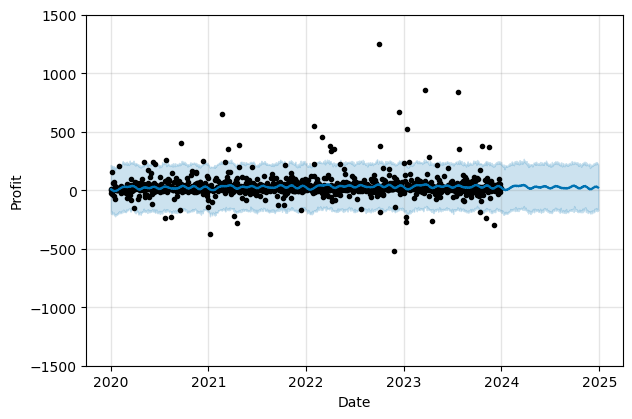

In [13]:
plot1 = m.plot(forecast)  

# Resize the plot
plot1.set_size_inches(6,4)

# gca --> "get the current axis" and set it to the desired name.
plot1.gca().set_xlabel("Date")
plot1.gca().set_ylabel("Profit")

# Set the limit of the y-axis
plot1.gca().set_ylim(-1500, 1500)

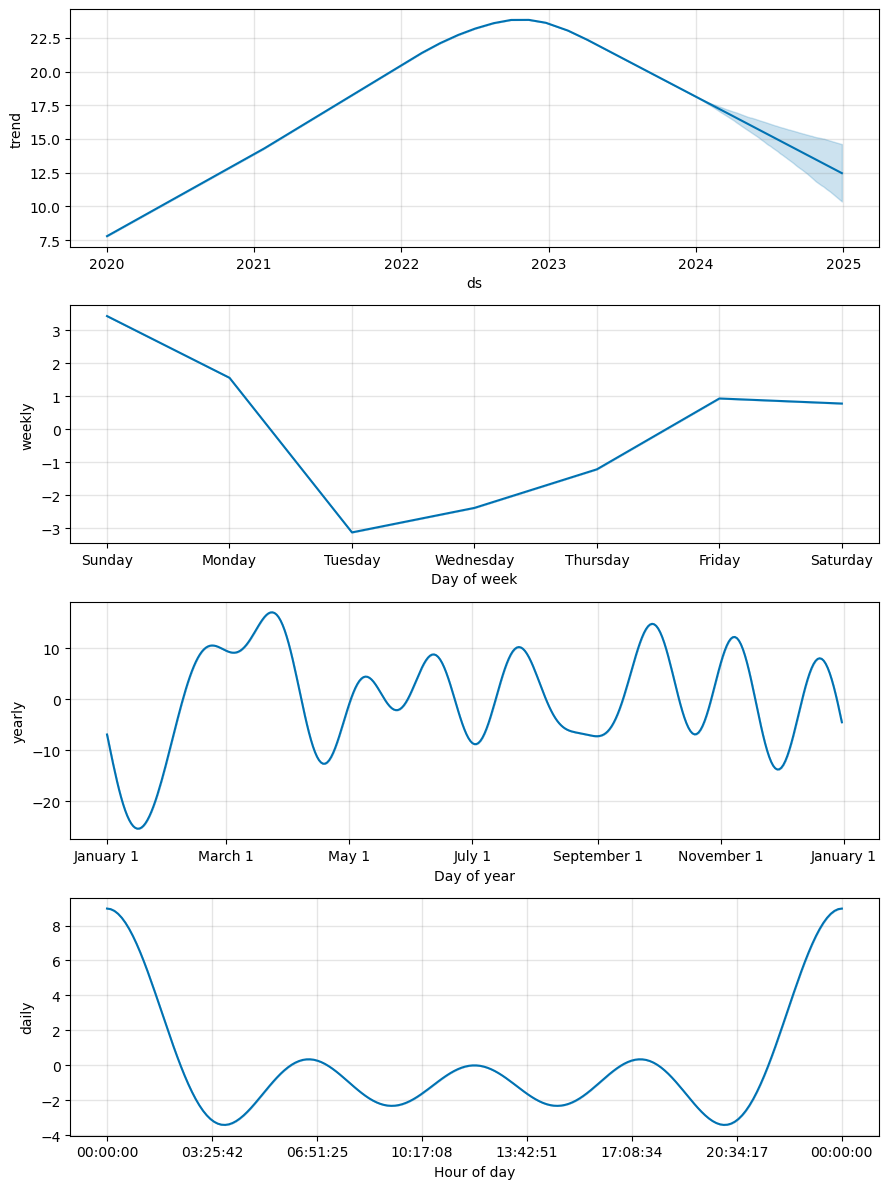

In [14]:
plt2 = m.plot_components(forecast)  ## high level of certainty   
# Maybe I want to add a chart for the trend in our original dataset 
## The chart is curved down -- explain
## Want to try another graph with 5 - 10 years of prediction. is it gonna be a sinusoid chart?